In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
from models import MLP_PINN, MLP_PINN_dot
from torchinfo import summary
net = MLP_PINN_dot(N_layers=8, width=32, loss_lambda=0.1, activation=nn.Softplus(30, 30), last_activation=nn.Identity()).to(device)
#summary(net)

In [4]:
import os
from utils.dataset import ImplicitDataset, batch_loader

dataset_name = '../datasets/box_1f0_gyroid_4pi'
#dataset_name = '../datasets/box_1.0'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)

# filter out discontinous points
grads = train_dataset.grads
norm_grad = torch.linalg.norm(grads, dim=1)
mark = torch.logical_and(norm_grad > 0.9, norm_grad < 1.1)
grads = grads[mark]
points = train_dataset.points[mark]
sdfs = train_dataset.sdfs[mark]
points.requires_grad_(True)

print(train_dataset)

ImplicitDataset (19683 points)


In [23]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
torch.nn.utils.clip_grad_norm_(net.parameters(), 10.0)
optimizer=torch.optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    #CallbackScheduler.reduce_lr(0.5),
    # CallbackScheduler.reduce_lr(0.2),
    # CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.nothing(),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=40, max_eval=60, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [33]:
from math import ceil

batch_size = len(train_dataset.points)
lr_step = 1000

LR_CALLBACK_EVERY_EPOCH = int(lr_step * ceil(len(train_dataset.points) / batch_size))
MAX_EPOCHS = int(LR_CALLBACK_EVERY_EPOCH * (len(lr_scheduler)+1))
PRINT_EVERY_EPOCH = int(MAX_EPOCHS // 10)

print(f'Max epoch: {MAX_EPOCHS} (PRINT: {PRINT_EVERY_EPOCH}, CALLBACK: {LR_CALLBACK_EVERY_EPOCH})')
net.loss_lambda = 10.0
try:
    epoch = 0
    while epoch < MAX_EPOCHS:

        # Training
        lr_scheduler.optimizer.zero_grad()
        
        loss = net.loss(points, sdfs, grads)
        loss.backward()
        lr_scheduler.optimizer.step(lambda: loss)

        lr_scheduler.step_when((epoch % LR_CALLBACK_EVERY_EPOCH) == LR_CALLBACK_EVERY_EPOCH - 1, verbose=True)
        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss_SDF:.6f} {net._loss_dot:.6f} {net._loss_residual:.6f}')

        epoch += 1
        
    print(f'#{epoch} Loss: {net._loss_SDF:.6f} {net._loss_dot:.6f} {net._loss_residual:.6f}\nSuccess')
except KeyboardInterrupt as e:
    print('Bye bye')


Max epoch: 3000 (PRINT: 300, CALLBACK: 1000)
#0 Loss: 0.000076 -0.994229 0.000702
#300 Loss: 0.000076 -0.994271 0.000684
#600 Loss: 0.000075 -0.994325 0.000669
#900 Loss: 0.000075 -0.994359 0.000652
Learning rate changed
#1200 Loss: 0.000074 -0.994410 0.000638
#1500 Loss: 0.000071 -0.994464 0.000627
#1800 Loss: 0.000070 -0.994483 0.000611
Learning rate changed
#2100 Loss: 0.000069 -0.994523 0.000599
#2400 Loss: 0.000068 -0.994534 0.000586
#2700 Loss: 0.000067 -0.994581 0.000576
Learning rate changed
#3000 Loss: 0.000067 -0.994598 0.000565
Success


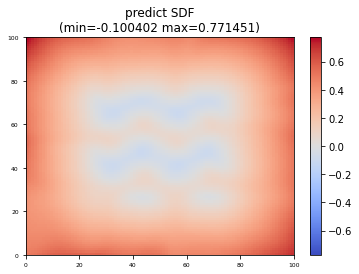

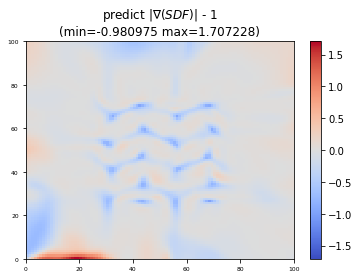

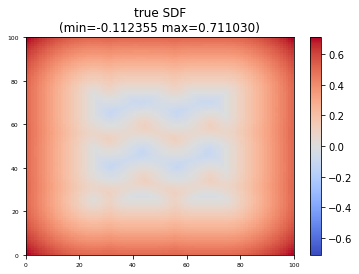

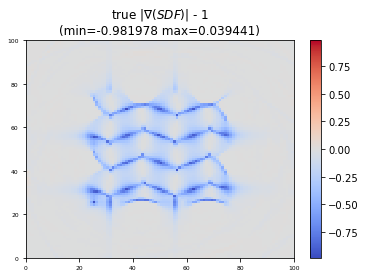

In [35]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0.01, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)

In [33]:
from utils.dataset import TestDataset
test_dataset = TestDataset(dataset_name+'_test.npz', device=device)
print('Uniform SDFS: ', net.test(test_dataset.uniform.points, test_dataset.uniform.sdfs).cpu().detach().numpy())
print('Uniform gradient: ', net.test_gradient(test_dataset.uniform.points, test_dataset.uniform.gradients).cpu().detach().numpy())
print('Random SDFS:', net.test(test_dataset.random.points, test_dataset.random.sdfs).cpu().detach().numpy())
print('Outside SDFS:', net.test(test_dataset.outside.points, test_dataset.outside.sdfs).cpu().detach().numpy())

Uniform SDFS:  9.662179e-05
Uniform gradient:  0.026583994
Random SDFS: 0.00025334614
Outside SDFS: 0.10373663
